# HYCOM-glider

In [1]:
import warnings
import iris

url = ('http://tds.marine.rutgers.edu/thredds/dodsC/projects/wilkin/'
       'mab-glider/Gridded/20130911T000000_20130920T000000_gp2013_modena.nc')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    glider = iris.load(url)


x = glider.extract_strict('Longitude').data
y = glider.extract_strict('Latitude').data
z = glider.extract_strict('Temperature').coord('depth').points
t = glider.extract_strict('Temperature').coord('time')
t = t.units.num2date(t.points)
s = glider.extract_strict('Temperature').data

### HYCOM

In [2]:
url = ('http://ecowatch.ncddc.noaa.gov/thredds/dodsC/'
       'hycom/hycom_reg1_agg/HYCOM_Region_1_Aggregation_best.ncd')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    cube = iris.load_cube(url, 'sea_water_temperature')

### Before reducing the cube to the glider space-time domain.

In [3]:
cube

<iris 'Cube' of sea_water_temperature / (degC) (time: 11963; depth: 40; latitude: 876; longitude: 626)>

In [4]:
from oceans import wrap_lon360
from ioos_tools.tardis import time_slice

bbox = wrap_lon360(min(x))[0], wrap_lon360(max(x))[0], min(y), max(y)

dx = dy = 0.08
cube = cube.intersection(longitude=(bbox[0]-dx, bbox[1]+dx),
                         latitude=(bbox[2]-dy, bbox[3]+dy))
cube = time_slice(cube, start=t[0], stop=t[-1])

### After reducing the cube to the glider space-time domain.

In [5]:
cube

<iris 'Cube' of sea_water_temperature / (degC) (time: 67; depth: 40; latitude: 7; longitude: 8)>

### Visualize the data.

In [6]:
%matplotlib inline
import numpy as np
import numpy.ma as ma
import seawater as sw
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def distance(x, y, units='km'):
    dist, pha = sw.dist(x, y, units=units)
    return np.r_[0, np.cumsum(dist)]


def plot_glider(ax, x, y, z, t, data, cmap=plt.cm.viridis, figsize=(15, 3), track_inset=False):
    dist = distance(x, y, units='km')
    z = np.abs(z)
    dist, z = np.broadcast_arrays(dist[..., np.newaxis], z)
    ax.pcolor(dist, z, data, cmap=cmap, snap=True)

    if track_inset:
        axin = inset_axes(ax, width="25%", height="30%", loc=4)
        axin.plot(x, y, 'k.')
        start, end = (x[0], y[0]), (x[-1], y[-1])
        kw = dict(marker='o', linestyle='none')
        axin.plot(*start, color='g', **kw)
        axin.plot(*end, color='r', **kw)
        axin.axis('off')
    return ax

### Glider track.

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

LAND = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                    edgecolor='face',
                                    facecolor=cfeature.COLORS['land'])


def plot_cube(cube, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(9, 13),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    lon = cube.coord(axis='X').points
    lat = cube.coord(axis='Y').points
    extent = [lon.min(), lon.max(),
              lat.min(), lat.max()]
    ax.set_extent(extent)
    ax.add_feature(LAND, zorder=0)
    ax.coastlines('10m', zorder=1)
    return fig, ax

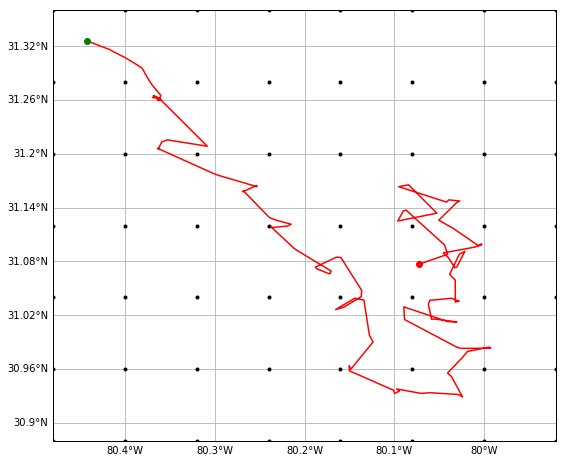

In [8]:
from gridgeo import GridGeo
from oceans import wrap_lon180

fig, ax = plot_cube(cube)

# Grid outline.
grid = GridGeo(cube)
xb, yb = grid.outline.boundary.xy
polygon = zip(xb, yb)

lon = wrap_lon180(cube.coord(axis='X').points)
lat = cube.coord(axis='Y').points
lon, lat = np.meshgrid(lon, lat)
ax.plot(lon, lat, 'k.')

# Glider track.
ax.plot(wrap_lon180(x), y, 'r')
ax.plot(wrap_lon180(x[0]), y[0], 'go')
ax.plot(wrap_lon180(x[-1]), y[-1], 'ro')

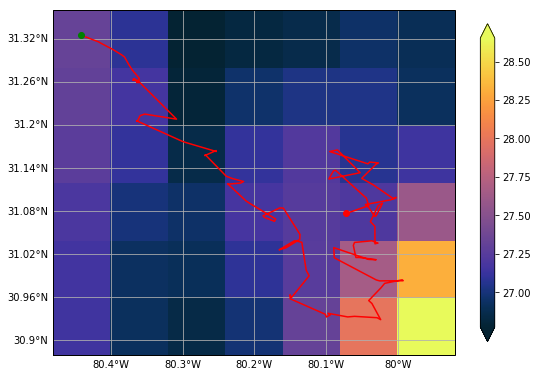

In [9]:
import cmocean

fig, ax = plot_cube(cube)

# Glider track.
ax.plot(wrap_lon180(x), y, 'r')
ax.plot(wrap_lon180(x[0]), y[0], 'go')
ax.plot(wrap_lon180(x[-1]), y[-1], 'ro')


# Variable at surface and last time step.
# (There is no _FillValue/missing_value!)
temp = ma.masked_greater_equal(cube[-1, 0, ...].data, 9.99999993e+36)
kw = dict(orientation='vertical', extend='both', shrink=0.45)
cs = ax.pcolormesh(lon, lat, temp,
                   cmap=cmocean.cm.thermal, zorder=0)
cbar = fig.colorbar(cs, **kw)

### Extract model coords.

In [10]:
from iris.analysis.trajectory import interpolate

track = [('longitude', wrap_lon180(x)),
         ('latitude', y),
         ('time', t)]

vgliver = interpolate(cube, track, method='linear')

/home/filipe/miniconda3/envs/IOOS/lib/python3.6/site-packages/iris/fileformats/netcdf.py:394: RuntimeWarning: invalid value encountered in greater
  data = variable[keys]


(80, 0)

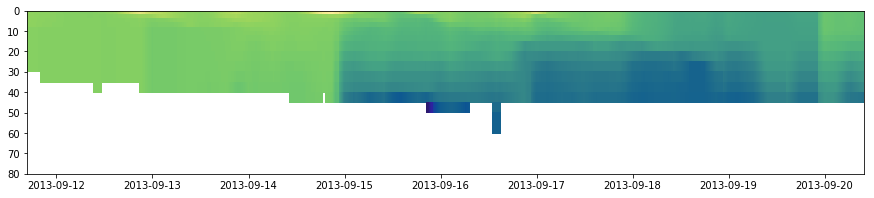

In [11]:
vertical = cube.coord('depth').points

fig, ax = plt.subplots(figsize=(15, 3))
ax.pcolormesh(t, vertical, np.ma.masked_invalid(vgliver.data),
              cmap=cmocean.cm.haline)
ax.invert_yaxis()
ax.set_ylim(80, 0)

### Glider and model data.

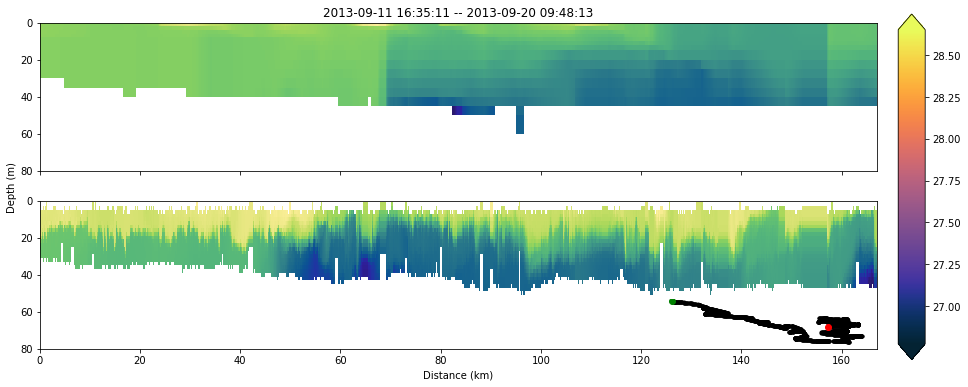

In [12]:
fig, (ax0, ax1) = plt.subplots(figsize=(15, 6), nrows=2, sharex=True, sharey=True)

data = np.ma.masked_invalid(vgliver.data).T
plot_glider(ax0, x, y, vertical, t, data,
            cmap=cmocean.cm.haline, track_inset=False)
plot_glider(ax1, x, y, z, t, s, cmap=cmocean.cm.haline, figsize=(15, 3), track_inset=True)

title = '{0:%Y-%m-%d %H:%M:%S} -- {1:%Y-%m-%d %H:%M:%S}'.format
ax0.set_title(title(t[0], t[-1]).format(t[0], t[-1]))
ax0.invert_yaxis()
ax0.set_ylim(80, 0)
ax1.set_xlabel('Distance (km)')
fig.text(0.095, 0.5, 'Depth (m)', va='center', rotation='vertical')

cax = fig.add_axes([0.92, 0.1, 0.025, 0.8])
kw = dict(orientation='vertical', extend='both', cax=cax)
cbar = fig.colorbar(cs, **kw)